In [1]:
# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')



from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import matplotlib.pyplot as plt
import numpy as np
# from skimage import transform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model 


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

modules loaded


In [2]:
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [4]:
data["label"].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [5]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [6]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [7]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [8]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


In [10]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=300
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [12]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [13]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= METRICS)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0

In [14]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=30 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/30
276/276 [==============================] - 19s 21ms/step - loss: 1.1613 - accuracy: 0.5817 - precision: 0.7725 - recall: 0.3920 - val_loss: 0.7299 - val_accuracy: 0.7448 - val_precision: 0.8347 - val_recall: 0.6329 - lr: 0.0010
Epoch 2/30
276/276 [==============================] - 4s 16ms/step - loss: 0.4734 - accuracy: 0.8418 - precision: 0.9032 - recall: 0.7776 - val_loss: 0.3333 - val_accuracy: 0.8844 - val_precision: 0.9123 - val_recall: 0.8555 - lr: 0.0010
Epoch 3/30
276/276 [==============================] - 4s 15ms/step - loss: 0.2760 - accuracy: 0.9073 - precision: 0.9312 - recall: 0.8830 - val_loss: 0.3325 - val_accuracy: 0.8755 - val_precision: 0.8959 - val_recall: 0.8553 - lr: 0.0010
Epoch 4/30
276/276 [==============================] - 4s 15ms/step - loss: 0.1912 - accuracy: 0.9351 - precision: 0.9477 - recall: 0.9237 - val_loss: 0.1843 - val_accuracy: 0.9346 - val_precision: 0.9419 - val_recall: 0.9292 - lr: 0.0010
Epoch 5/30
276/276 [===========================

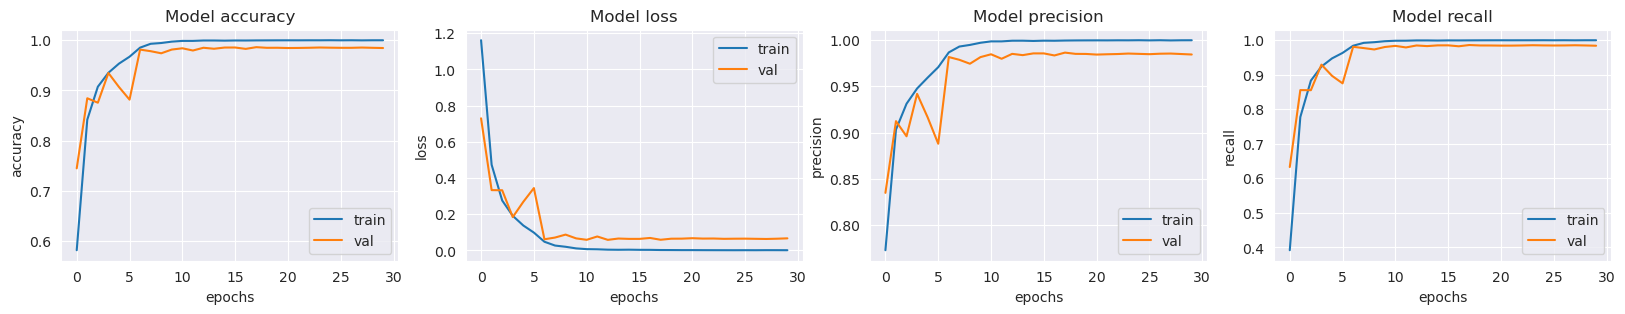

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss','precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

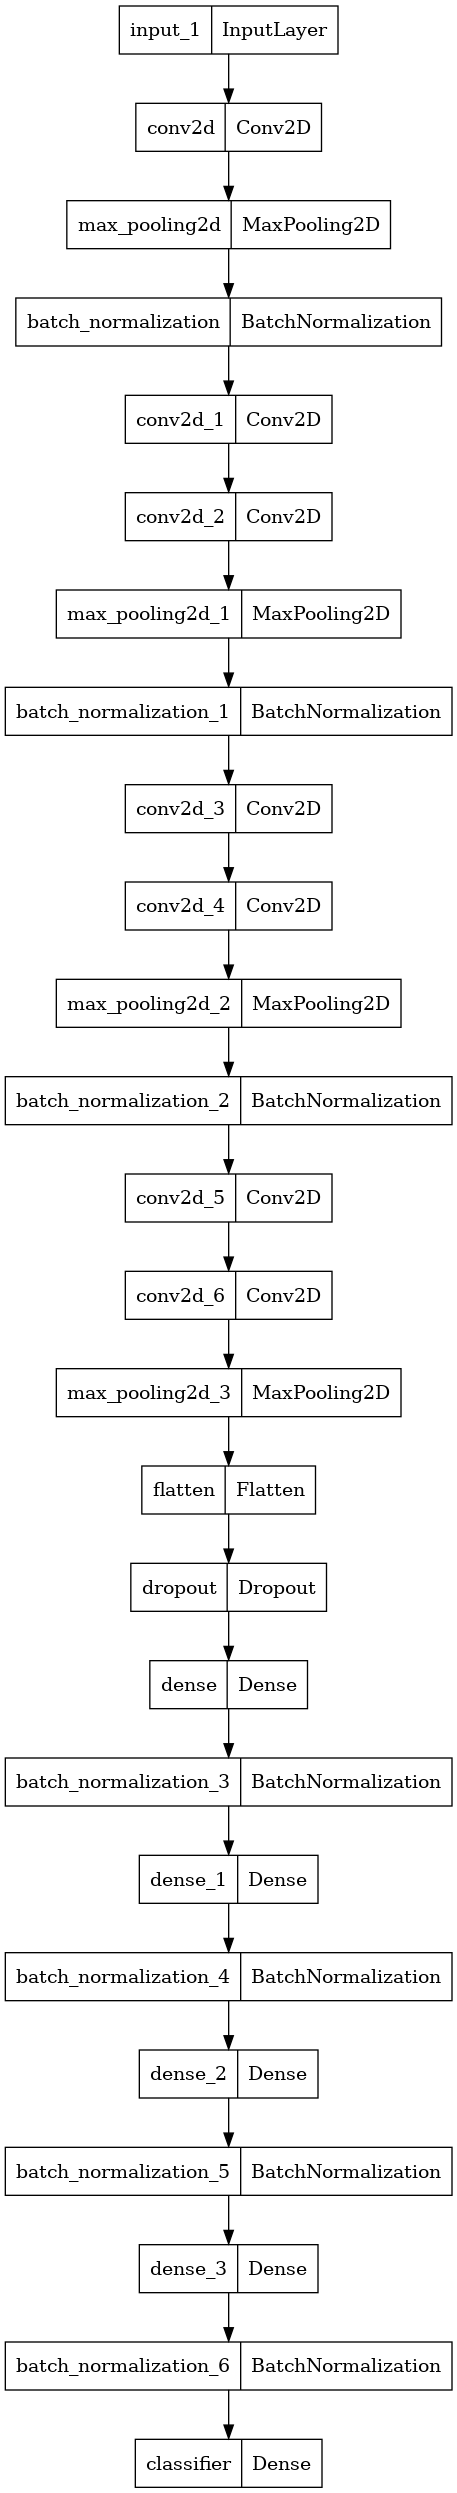

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
kappa = cohen_kappa_score(y_test_classes, y_pred_classes)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Kappa Score:", kappa)



367/367 [==============================] - 2s 3ms/step
Accuracy: 0.9844042952104994
Precision: 0.9849544385367072
Recall: 0.9843666430235622
F1-score: 0.9843348959112284
Kappa Score: 0.9818024746787669


**Show training history**

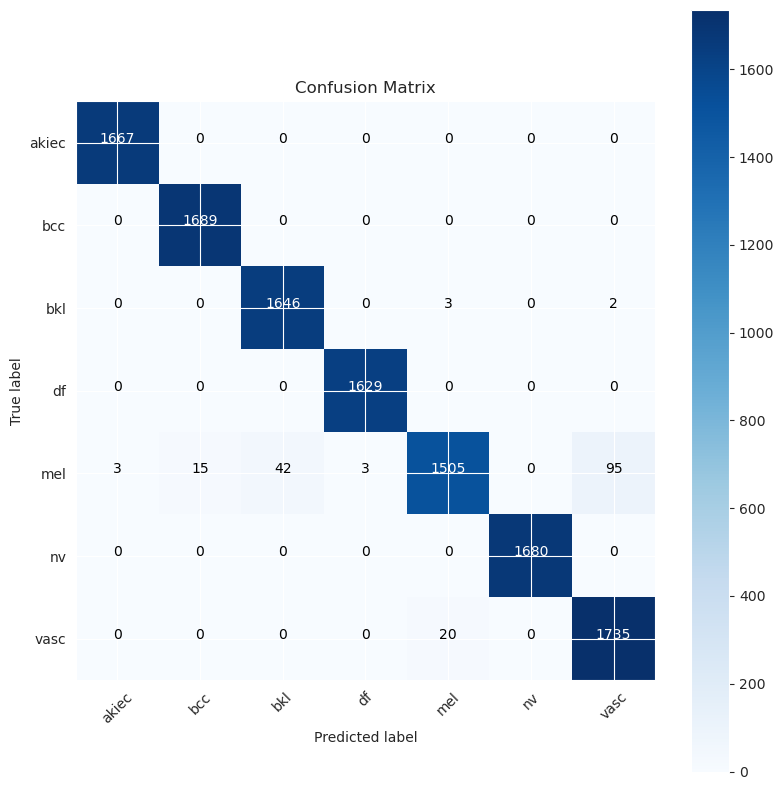

In [18]:
# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Save model**

In [19]:
# model.save('SkinCancerDetection.h5')